In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from datetime import datetime, timedelta
import random
from cartopy import crs as ccrs, feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import xarray as xr
from netCDF4 import Dataset
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
import math as m
import os

In [5]:
YES = 1
NO = 0

### Auxilary functions

In [6]:
def get_distance(lat1, lat2, lon1, lon2, R):
    """Calculate distance between start and end points using Harvesin formula
    Result in meters (m)!"""
    # Convert lat and lon to radians for the formula
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    a = np.power(np.sin((lat2-lat1) / 2), 2) + np.cos(lat1) * np.cos(lat2) * np.power(np.sin((lon2-lon1) / 2), 2)
    distance = 2 * R * np.arcsin(np.sqrt(a))
    return distance * 1000

def get_angle(point1, point2):
    """ Get angle (in radians) of segment of line with respect to x-axis"""
    y2 = point2[1]
    x2 = point2[0]
    y1 = point1[1]
    x1 = point1[0]

    if x1 == x2:
        theta = m.pi/2 if y2 > y1 else -m.pi/2  # 0 degrees for North, -180 for South
    else:
        slope = (y2-y1)/(x2-x1)
        theta = np.arctan(slope)

    return theta

def get_velocity (u, v, theta):
    """ Compute the velocity based on u (x-axis) and v (y-axis) velocities and the angle theta (relative to x-axis)"""
    return u*np.sin(theta) + v*np.cos(theta)



def find_angle_variations(lats, lons, a):
    """Computes the angle between two consecutive stations and detects angles above a degrees.
       Stores the coordinates where these variations are detected. """
    
    thetas = []
    borders_idx = []
    borders_idx.append(0)

    if len(lats) != len(lons):
        print("Lats and lons should have same dimensions.")
        return None, None
    
    for i in range(len(lats) - 1):
        lat1, lon1 = lats[i], lons[i]
        lat2, lon2 = lats[i + 1], lons[i + 1]
        
        angle = get_angle([lon1, lat1], [lon2, lat2])
            
        if len(thetas) > 0 and abs(angle - thetas[-1]) > np.radians(a):
            borders_idx.append(i)

        thetas.append(angle)

    borders_idx = [borders_idx[0]] + [borders_idx[j] for j in range(1, len(borders_idx)) if (borders_idx[j] - borders_idx[j-1]) > 2]
    borders_idx.append(i+1)

    return thetas, borders_idx

### Data 

In [7]:
file_path = 'data/HD_Monthly_Data_19932020.nc'
data = xr.open_dataset(file_path)
data

<xarray.Dataset> Size: 53GB
Dimensions:    (depth: 40, latitude: 265, longitude: 457, time: 336)
Coordinates:
  * depth      (depth) float32 160B 0.494 1.541 2.646 ... 1.684e+03 1.942e+03
  * latitude   (latitude) float32 1kB 44.0 44.08 44.17 ... 65.83 65.92 66.0
  * longitude  (longitude) float32 2kB -30.0 -29.92 -29.83 ... 7.833 7.917 8.0
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2020-12-01
Data variables:
    so         (time, depth, latitude, longitude) float64 13GB ...
    thetao     (time, depth, latitude, longitude) float64 13GB ...
    bottomT    (time, latitude, longitude) float64 326MB ...
    uo         (time, depth, latitude, longitude) float64 13GB ...
    vo         (time, depth, latitude, longitude) float64 13GB ...
    mlotst     (time, latitude, longitude) float64 326MB ...
    zos        (time, latitude, longitude) float64 326MB ...
Attributes: (12/15)
    Conventions:                       CF-1.6
    area:                              GLOBAL
    contact:                           servicedesk.cmems@mercator-ocean.eu
    credit:                            E.U. Copernicus Marine Service Informa...
    dataset:                           global-reanalysis-001-030-monthly
    institution:                       Mercator Ocean
    ...                                ...
    product_user_manual:               http://marine.copernicus.eu/documents/...
    quality_information_document:      http://marine.copernicus.eu/documents/...
    references:                        http://marine.copernicus.eu
    source:                            MERCATOR GLORYS12V1
    title:                             Monthly mean fields for product GLOBAL...
    copernicus_marine_client_version:  0.10.7

In [127]:
file_path = 'data/GLO-MFC_001_030_mask_bathy.nc'
bathy = xr.open_dataset(file_path)
bathy

<xarray.Dataset> Size: 511MB
Dimensions:     (depth: 50, latitude: 2041, longitude: 4320)
Coordinates:
  * latitude    (latitude) float32 8kB -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude   (longitude) float32 17kB -180.0 -179.9 -179.8 ... 179.8 179.9
  * depth       (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
Data variables:
    mask        (depth, latitude, longitude) int8 441MB ...
    deptho      (latitude, longitude) float32 35MB ...
    deptho_lev  (latitude, longitude) float32 35MB ...
Attributes: (12/13)
    title:                Bathymetry and mask for product GLOBAL_REANALYSIS_P...
    references:           http://marine.copernicus.eu
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    contact:              servicedesk.cmems@mercator-ocean.eu
    producer:             CMEMS - Global Monitoring and Forecasting Centre
    ...                   ...
    Conventions:          CF-1.6
    area:                 GLOBAL
    source:               GLORYS12V1
    product:              GLOBAL_REANALYSIS_PHY_001_030
    dataset:              global-reanalysis-phy-001-030-statics
    product_user_manual:  http://marine.copernicus.eu/documents/PUM/CMEMS-GLO...

### Functions for grid and interpolation

In [153]:
class Transect:
    def __init__(self, lat1, lat2, lon1, lon2, i, month, year) -> None:

        self.label = i
        self.month = month
        self.year = year
        self.theta = get_angle([lon1,lat1], [lon2,lat2])
        self.distance = get_distance(lat1, lat2, lon1, lon2, 6371)
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2

        self.velocities = []
        self.data_points = []

class TransectInfo:
    def __init__(self, lat1, lat2, lon1, lon2, i, params) -> None:

        self.label = i
        self.theta = get_angle([lon1,lat1], [lon2,lat2])
        self.distance = get_distance(lat1, lat2, lon1, lon2, 6371)
        self.lats = []
        self.lons = []
        self.depths = []
        self.distances = []
        self.num_cells_x = 10
        self.num_cells_z = 10

        self.grid_points = []
        self.params = params
        
        
    def print_info(self):

        print(f"Initial coordinates: ({self.lats[0]}, {self.lons[0]})")
        print(f"Final coordinates: ({self.lats[-1]}, {self.lons[-1]})")

        print(f"Transect no.{self.label}")
        print(f"Angle theta = {np.degrees(self.theta)}")
        print(f"Total distance d = {self.distance / 1000} km")
        print(f"Number of horizontal cells = {len(self.lons)-1}")
    
        
class Box:
    def __init__(self, lat1, lat2, lon1, lon2, params) -> None:
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2
        self.vdistance = get_distance(lat1, lat2, lon1, lon1, R=6371)
        self.hdistance = get_distance(lat1, lat1, lon1, lon2, R=6371) 
        self.num_cells_lat = 5
        self.num_cells_lon = 10
        self.num_cells_dep = 10
        self.lats = np.linspace(lat1, lat2, self.num_cells_lat + 1)
        self.lons = np.linspace(lon1, lon2, self.num_cells_lon + 1)
        self.depths = np.linspace(params['min_depth'], params['max_depth'], self.num_cells_dep + 1)
        self.grid = []
        self.info_transects = []


In [97]:
def get_transect_grid(lat1, lat2, lon1, lon2, i, params):
    ''' Generates grid for a given transect both horizontally and vertically.
        Returns transect with detailed info. '''
    transect = TransectInfo(lat1, lat2, lon1, lon2, i, params)

    # Create a regular grid of coordinates over the transect, and use the depths from GLORYS
    # But we also need the depth and coordinates at center of each cell to get the variables of interest at the center of each cell 
    transect.depths = np.linspace(params['min_depth'], params['max_depth'], transect.num_cells_z + 1)
    transect.lats = np.linspace(lat1, lat2, transect.num_cells_x + 1)
    transect.lons = np.linspace(lon1, lon2, transect.num_cells_x + 1)

    mid_depths = (transect.depths[:-1] + transect.depths[1:]) / 2
    mid_lats = (transect.lats[:-1] + transect.lats[1:]) / 2
    mid_lons = (transect.lons[:-1] + transect.lons[1:]) / 2 

    points_lat_lon = np.column_stack((mid_lats, mid_lons))
    transect.grid_points = []
    for (lat, lon) in points_lat_lon:
        for depth in mid_depths:
            transect.grid_points.append((lat, lon, depth))

    # We need a fictional axis that goes along the transect for when calculating the flow
    transect.distances = [
        get_distance(lat1, transect.lats[j], lon1, transect.lons[j], 6371)
        for j in range(transect.num_cells_x + 1)
    ]
    
    return transect


def get_box_grid(lats1, lats2, lons1, lons2, params, R=6371):
    ''' Generates horizontal and vertical grid for a rectangular box (set of transects). 
        Returns list of transects with detailed info.'''
    
    # Get horizontal and vertical length of box 
    box = Box(lats1, lats2, lons1, lons2, params)
    print(f"Vertical distance = {box.vdistance/1000} km \nHorizontal distance = {box.hdistance/1000} km")

    lats_grid, lons_grid, depths_grid = np.meshgrid(box.lats, box.lons, box.depths, indexing='ij')

    stations = pd.DataFrame({
        'Latitude': lats_grid.flatten(),
        'Longitude': lons_grid.flatten(),
        'Depth': depths_grid.flatten()
    })

    mid_lats = (box.lats[:-1] + box.lats[1:]) / 2
    mid_lons = (box.lons[:-1] + box.lons[1:]) / 2
    mid_depths = (box.depths[:-1] + box.depths[1:]) / 2

    box.grid = np.array(np.meshgrid(mid_lats, mid_lons, mid_depths, indexing='ij')).T.reshape(-1,3)

    # Get regularly spaced grid for each same-latitude transect
    box.info_transects = []
    for i, lat in enumerate(box.lats[:-1]):
    
        transect = TransectInfo(lat, lat, lons1, lons2, i, params)
        grid = np.array(box.grid)
        transect.grid_points = grid[grid[:, 0] == mid_lats[i]]
        transect.lons = box.lons
        transect.lats = [lat for i in range(len(box.lons))]
        transect.depths = box.depths
        transect.distances = [get_distance(lat, lat, lons1, transect.lons[j], 6371) for j in range(len(transect.lons))]
        
        # info = get_transect_grid(lat, lat, lons1, lons2, i, params)
        transect.print_info()
        # info_transects.append(info)
        box.info_transects.append(transect)

    return box, stations


def generate_transect_values(month, year, data, info, method):
    ''' Prepares the necessary data and fills the values of all variables:
    - Latitude, Longitude and Depth grid
    - Mid Latitude, Longitude and Depth of each grid cell'''
    
    # method = 'nearest'
    lat1 = info.lats[0]
    lat2 = info.lats[-1]
    lon1 = info.lons[0]
    lon2 = info.lons[-1]
    print(lat1, lon1, lat2, lon2)

    # Prepare data from GLORYS to use for the interpolation
    # Filter the original dataset used for the interpolation to reduce computational cost (both time and memory)
    df_transect = data[(data['latitude'] >= min(lat1,lat2) - 0.640000) & (data['latitude'] <= max(lat1,lat2) + 0.640000) 
                     & (data['longitude'] >= min(lon1,lon2) - 0.640000000) & (data['longitude'] <= max(lon1,lon2) + 0.640000000)]
    
    df_transect = df_transect.sample(n=min(int(10/100 * len(df_transect)), len(df_transect)), random_state=123)
    data_points = df_transect[['latitude', 'longitude', 'depth']]
    
 
    ## In case you want to store more data for further analysis : WARNING: IT WILL INCREASE RUNNING TIME
    # print("Starting interpolations...")
    # transect.temps = griddata(data_points.values, df_transect['thetao'], info.grid_points, method=method)
    # transect.sals = griddata(data_points.values, df_transect['so'], info.grid_points, method=method)
    uos = griddata(data_points.values, df_transect['uo'], info.grid_points, method=method)
    vos = griddata(data_points.values, df_transect['vo'], info.grid_points, method=method)

    velocities = get_velocity(uos, vos, info.theta)

    return uos, vos



In [98]:
# min_lon, max_lon, min_lat, max_lat = -23, -3, 52, 70

def format_lon_label(x):
    return f"{abs(x):.1f}°{'W' if x < 0 else 'E'}"

def format_lat_label(y):
    return f"{abs(y):.1f}°{'S' if y < 0 else 'N'}"

#### STATIONS & TRANSECTS & ANGLES
def plot_stations_in_map(c_a, c_st, stations, thetas, trans_idx, subtransects):
    ''' Plots stations in the map with optional angles relative to longitude axis as color of the station point, 
    and optional regularly spaced transects on top.
     To enable these features, first two input variables must be YES. '''

    projection = ccrs.PlateCarree()
    plt.figure(figsize=(10,8))
    ax = plt.axes(projection=projection)
    ax.set_extent([-23, -3, 52, 70], crs=projection)

    # Customize the plot
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

    if c_a == YES:
        thetas_t = thetas.copy()  
        thetas_t.append(0)
        color = c=np.degrees(thetas_t)
    else:
        color = 'black'
    scatter = plt.scatter(stations['Longitude'], stations['Latitude'], c=color, 
                              s=50, transform=ccrs.PlateCarree(), edgecolor='black')
    
    if c_a == YES:
        cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)
        cbar.set_label('Theta (degrees)', fontsize=12)
        cbar.set_ticks(np.arange(-90, 91, 30))  # Adjust ticks as necessary

    if c_st == YES:
        for i in range(0, len(trans_idx)-1):
            plt.plot(subtransects[i].lons, subtransects[i].lats, c='red', transform=ccrs.PlateCarree(), linewidth=3)

        plt.plot([],[], c='red', label='Subtransects', linewidth=3) 
    plt.scatter([],[], c='black', label='Ellet Line stations', s=20, edgecolor='black')
    # plt.plot([],[], c='darkred', label='Transition between transects', linewidth=3)

    plt.title('Stations along transect')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

####


#### DATA USED
def plot_data_used(stations, subtransects, trans_idx):
    '''Plots in the map all the data used, including stations / coordinates of transect, 
    coordinates of data points and "fake" transects used for interpolation. '''

    projection = ccrs.PlateCarree()
    plt.figure(figsize=(10,10))

    ax = plt.axes(projection=projection)
    ax.set_extent([-23, -3, 52, 70], crs=projection)  
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

    for i in range(0, len(trans_idx)-1):
        plt.scatter(subtransects[i].data_points['longitude'], subtransects[i].data_points['latitude'], c='orange', s=2, transform=ccrs.PlateCarree())
    plt.scatter(stations['Longitude'], stations['Latitude'], c='black', s=20, transform=ccrs.PlateCarree(), edgecolor='black')
    for i in range(0, len(trans_idx)-1):
        plt.scatter(subtransects[i].lons, subtransects[i].lats, c='white', s=20, transform=ccrs.PlateCarree(), edgecolor='black')

    plt.scatter(1,1, c='black', label='Ellet Line stations', s=20, edgecolor='black')
    plt.scatter(1,1, c='orange', label='GLORYS data', s=20) 
    plt.scatter(1,1, c='white', label='Regularly spaced transects', s=20, edgecolor='black')

    plt.title('Spatial distribution of data used: Ellet Line, GLORYS data, interpolated transect')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()
####

#### VELOCITIES MAGNITUDES
def plot_variable_in_3D(dir_or_mag, variable, grid_points, variable_name):
    '''Plot in 3D the velocities accross the transect. Another function does the same for flows.
    An option is also given between presenting the magnitude of the values or only the signal.'''

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    if variable_name == 'velocity':
        units = 'm/s'
        title = 'Velocity over the Transect'
        labelv = 'Velocity (m/s)'

    elif variable_name == 'temperature':
        units = 'degrees Celcius'
        title = 'Temperature over the Transect'
        labelv = 'Temperature (degrees Celcius)'

    if variable_name == 'salinity':
        units = 'PSU'
        title = 'Salinity over the Transect'
        labelv = 'Salinity (PSU)'
    
    
    # Find global min and max across all transects
    minv, maxv = float('inf'), float('-inf')

    minv = min(np.nanmin(variable), minv)
    maxv = max(np.nanmax(variable), maxv)
    cbar_limit = max(abs(minv), abs(maxv))

    # Color bar
    colors = ["red", "yellow", "green"]
    cmap_name = "custom_vivid"
    cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
    cmap.set_bad(color='grey')  # NaN values as grey

    # Plot each transect with the same color scale

    grid_lats, grid_lons, grid_depths = zip(*grid_points)

    if variable_name == 'velocity' and dir_or_mag == 'magnitude':
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=variable, 
                    cmap=cmap, s=50, vmin=-cbar_limit, vmax=cbar_limit, 
                    label='Data Points')
        
        cbar = fig.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label({labelv})
        cbar.set_ticks([minv, 0, maxv])

    elif variable_name == 'velocity' and dir_or_mag == 'direction':
        # sizes = np.clip((np.abs(transect.velocities) / maxv) * 50, 0, 50)
        colors = ['red' if v < 0 else 'green' if v > 0 else 'white' for v in variable]
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=colors, s=50)

        ax.scatter([], [], [], c='green', label='Positive Points')
        ax.scatter([], [], [], c='red', label='Negative Points')

    
    elif variable_name == 'temperature' or variable_name == 'salinity':
        sc = ax.scatter(grid_lons, grid_lats, grid_depths, c=variable, 
                    cmap=cmap, s=50, vmin=minv, vmax=maxv, 
                    label='Data Points')
        
        cbar = fig.colorbar(sc, ax=ax, orientation='vertical')
        cbar.set_label(labelv)
        cbar.set_ticks(np.linspace(minv, maxv, 5))


    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth')
    ax.invert_zaxis() 
    ax.view_init(elev=45, azim=-30)
    ax.xaxis.set_major_formatter(LongitudeFormatter())  
    ax.yaxis.set_major_formatter(LatitudeFormatter())  
    ax.legend()

    plt.title(f"Velocity along Transect {title}")
    plt.show()
#####


### Function for calculation of flow

In [99]:
def calculate_flux(distances, depths, velocities):
    ''' Calculates the transport through a grid with known velocity values.
    All values should be in meters (m) !'''
    # print("Calculating flux")
    Q = 0.0
    A = 0.0
    diffs_x = np.abs(np.diff(np.array(distances)))
    diffs_z = np.abs(np.diff(depths)) 

    # Check if velocities can be reshaped to the desired shape
    if velocities.size == len(diffs_z) * len(diffs_x):
        # Check if the shape matches, if not, reshape
        if velocities.shape[0] != len(diffs_z) or velocities.shape[1] != len(diffs_x): 
            velocities = velocities.reshape(len(diffs_z), len(diffs_x))
    else:
        raise ValueError("Cannot reshape velocities to shape ({}, {}). Dimensions do not match.".format(len(diffs_z), len(diffs_x)))


    for i in range(len(diffs_z)):  
        for j in range(len(diffs_x)): 
            if not np.isnan(velocities[i,j]):
                A += diffs_z[i] * diffs_x[j]
                Q += diffs_z[i] * diffs_x[j] * velocities[i,j]
    
    print("Flux calculated!")

    return Q, A



#### Calculation of integrated flow through box

1. Creates grid inside the box - parallel transects within the box
2. Calculates flow along the several transects
3. Integrates the flow rate over the box
4. Repeates for entire time period (monthly resolution)

#### Grid & transects

In [100]:
# THE BOX

#          ts
#     ----------- 55N
#     |         |
#  ls |         | rs
#     |         |
#     ----------- 52N
#   17W    bs     12W

In [101]:
# Limits of the box
lats1 = 52
lats2 = 55
lons1 = -12
lons2 = -17
R = 6371

params = {
            'delta_distance': 25000, # m
            'delta_depth': 25, # m
            'max_depth': 300, # m
            'min_depth': 0, # m
            'precision': 5 # decimal points
        }

# num_cells_x = 10
# num_cells_z = 10

# lats = np.linspace(lats1, lats2, 5 + 1)
# lons = np.linspace(lons1, lons2, num_cells_x + 1)
# depths = np.linspace(params['min_depth'], params['max_depth'], num_cells_z)

# lats_grid, lons_grid, depths_grid = np.meshgrid(lats, lons, depths, indexing='ij')
# lats_flat = lats_grid.flatten()
# lons_flat = lons_grid.flatten()
# depths_flat = depths_grid.flatten()

# stations = pd.DataFrame({
#     'Latitude': lats_flat,
#     'Longitude': lons_flat,
#     'Depth': depths_flat
# })

# mid_lats = (lats[:-1] + lats[1:]) / 2
# mid_lons = (lons[:-1] + lons[1:]) / 2
# mid_depths = (depths[:-1] + depths[1:]) / 2

# grid_points = np.array(np.meshgrid(mid_lats, mid_lons, mid_depths, indexing='ij')).T.reshape(-1,3)


In [151]:
box, stations = get_box_grid(lats1, lats2, lons1, lons2, params)
box.info_transects[0].print_info()

Vertical distance = 333.584779933676 km 
Horizontal distance = 342.22470323090886 km
Initial coordinates: (52.0, -12.0)
Final coordinates: (52.0, -17.0)
Transect no.0
Angle theta = -0.0
Total distance d = 342.22470323090886 km
Number of horizontal cells = 10
Initial coordinates: (52.6, -12.0)
Final coordinates: (52.6, -17.0)
Transect no.1
Angle theta = -0.0
Total distance d = 337.6179224043432 km
Number of horizontal cells = 10
Initial coordinates: (53.2, -12.0)
Final coordinates: (53.2, -17.0)
Transect no.2
Angle theta = -0.0
Total distance d = 332.9741537961402 km
Number of horizontal cells = 10
Initial coordinates: (53.8, -12.0)
Final coordinates: (53.8, -17.0)
Transect no.3
Angle theta = -0.0
Total distance d = 328.2939070881094 km
Number of horizontal cells = 10
Initial coordinates: (54.4, -12.0)
Final coordinates: (54.4, -17.0)
Transect no.4
Angle theta = -0.0
Total distance d = 323.57769592649953 km
Number of horizontal cells = 10
Initial coordinates: (52.0, -12.0)
Final coordin

In [251]:
bathy_data = bathy.sel(depth=slice(0, 1))
bathy_data = bathy_data.sel(latitude=slice(49, 70))
bathy_data = bathy_data.sel(longitude=slice(-23, -3))
df_bathy = bathy_data.to_dataframe().reset_index()

df_bathy_1000 = df_bathy[(df_bathy['deptho'] <= 1050) & (df_bathy['deptho'] >= 950)]
df_bathy_1000_top = df_bathy_1000[(df_bathy_1000['latitude'] <= 56) & (df_bathy_1000['latitude'] >= 55)]
df_bathy_1000_bottom = df_bathy_1000[(df_bathy_1000['latitude'] <= 48) & (df_bathy_1000['latitude'] >= 54)]
df_bathy_1000_bottom, df_bathy_1000_top, df_bathy_1000

(Empty DataFrame
 Columns: [depth, latitude, longitude, mask, deptho, deptho_lev]
 Index: [],
           depth   latitude  longitude  mask       deptho  deptho_lev
 17410  0.494025  55.000000 -18.166666     1   992.981812        35.0
 17421  0.494025  55.000000 -17.250000     1   953.092529        35.0
 17422  0.494025  55.000000 -17.166666     1  1011.504028        35.0
 17651  0.494025  55.083332 -18.166666     1  1018.599976        35.0
 17664  0.494025  55.083332 -17.083334     1   955.908875        35.0
 17665  0.494025  55.083332 -17.000000     1  1021.692017        35.0
 17892  0.494025  55.166668 -18.166666     1  1044.447998        35.0
 17893  0.494025  55.166668 -18.083334     1   975.621826        35.0
 17907  0.494025  55.166668 -16.916666     1   962.147278        35.0
 17908  0.494025  55.166668 -16.833334     1  1006.000000        35.0
 17988  0.494025  55.166668 -10.166667     1  1023.791016        35.0
 18134  0.494025  55.250000 -18.083334     1   996.136597        3

In [252]:
stations_df = pd.read_excel('data/Ellet_Stations.xlsx')[:36]
stations_df

,Station,Latitude,Longitude,Nominal.Depth.(m),Unnamed: 4
0,IG,56.667,-6.133,190,0
1,2G,56.683,-6.283,30,1
2,3G,56.708,-6.367,70,2
3,4G,56.733,-6.450,115,3
4,5G,56.733,-6.600,80,4
5,6G,56.733,-6.750,40,5
6,7G,56.733,-7.000,140,6
7,8G,56.733,-7.167,170,7
8,9G,56.733,-7.333,160,8
9,IOG,56.733,-7.500,215,9


In [271]:
tlat1 = 51
tlon1 = -13.8
tlat2 = 55.3
tlon2 = -16.7
transectP = get_transect_grid(tlat1, tlat2, tlon1, tlon2, 0, params)
transectP.lats, transectP.lons

(array([51.  , 51.43, 51.86, 52.29, 52.72, 53.15, 53.58, 54.01, 54.44,
        54.87, 55.3 ]),
 array([-13.8 , -14.09, -14.38, -14.67, -14.96, -15.25, -15.54, -15.83,
        -16.12, -16.41, -16.7 ]))

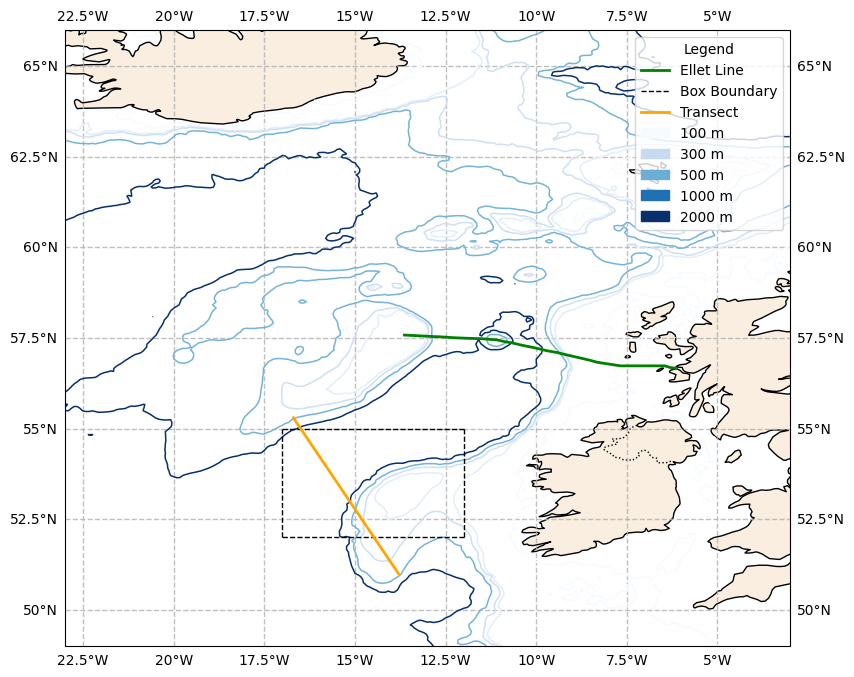

In [273]:

projection = ccrs.PlateCarree()
plt.figure(figsize=(10,8))
ax = plt.axes(projection=projection)
ax.set_extent([-23, -3, 49, 66], crs=projection)  
gl = ax.gridlines(draw_labels=True, linestyle='--', linewidth=1, alpha=0.8)

# Plot the data points
contour_levels = [100, 300, 500, 1000, 2000]
deptho = np.array(df_bathy['deptho']).reshape(len(df_bathy['latitude'].unique()), len(df_bathy['longitude'].unique()))
# scatter = plt.scatter(df_bathy['longitude'], df_bathy['latitude'], c=df_bathy['deptho'], s=5, transform=ccrs.PlateCarree())
contour = ax.contour(df_bathy['longitude'].unique(), df_bathy['latitude'].unique(), deptho, cmap='Blues', levels=contour_levels, linewidths=1.1,transform=ccrs.PlateCarree())
# scatter = plt.scatter(box.grid[:, 1], box.grid[:, 0], c='black', s=10, transform=ccrs.PlateCarree(), label='Sample Points')
scatter = plt.plot(stations_df['Longitude'], stations_df['Latitude'], c='green', linewidth=2, transform=ccrs.PlateCarree(), label='Ellet Line')


# Generate colors for each level using the updated 'Blues' colormap
cmap = plt.get_cmap('Blues')
colors = [cmap(i / (len(contour_levels) - 1)) for i in range(len(contour_levels))]


plt.plot([box.lon1, box.lon2], [box.lat1, box.lat1], color='black', linewidth=1, label="Box Boundary", linestyle='--')
plt.plot([box.lon1, box.lon2], [box.lat2, box.lat2], color='black', linewidth=1, linestyle='--')
plt.plot([box.lon1, box.lon1], [box.lat1, box.lat2], color='black', linewidth=1, linestyle='--')
plt.plot([box.lon2, box.lon2], [box.lat1, box.lat2], color='black', linewidth=1, linestyle='--')

scatterP = plt.plot(transectP.lons, transectP.lats, c='orange', linewidth=2, transform=ccrs.PlateCarree(), label='Transect')

# Get handles and labels for plot elements
handles, labels = ax.get_legend_handles_labels()
legend_patches = [
    mpatches.Patch(color=colors[i], label=f'{contour_levels[i]} m')
    for i in range(len(contour_levels))
]
all_handles = handles + legend_patches
all_labels = labels + [f'{level} m' for level in contour_levels]

# Customize the plot
ax.coastlines()
ax.add_feature(cfeature.LAND, facecolor='#F9EEE0')
# ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.xaxis.set_major_formatter(LongitudeFormatter())  
ax.yaxis.set_major_formatter(LatitudeFormatter())  

plt.legend(all_handles, all_labels, title="Legend", loc='upper right')
# plt.title('Stations along Porcupine Bank')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Flow calculation

In [104]:
method = 'linear'

In [105]:
flow_df = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = pd.to_datetime(data.time).year.unique()

transects_per_year = []
years = [1993]
for year in years:

    # Selecting data for analysing that year
    data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    months = pd.to_datetime(data.time).month.unique()

    transects_by_month = []
    months = [1]
    for month in months:

        Q = 0.0
        A = 0.0
        Q_array = []
        A_array = []
        for grid in grids_:

            # Prepare data for velocity interpolation and calculation
            data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))
            df = data_month.to_dataframe().reset_index()
            variables = ['so', 'thetao', 'uo', 'vo']
            df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)
            print("Data prepared")
            # Velocity interpolation and calculation
            velocities = generate_transect_values(month, year, df, grid, method)
            print("Transect values generated")
            # Calculate flux in the transect
            Q_transect, A_transect = calculate_flux(grid.distances, grid.depths, velocities)
            print(f"Transect no.{grid.label}")
            print(f"total Q = {np.round(Q_transect/1000000, 4)} Sv")
            Q_array.append(Q_transect)
            A_array.append(A_transect)

        # Q = np.sum(np.array(Q_array) * np.array(A_array)) * (grid.distance / grid.num_cells_z)
        # A += (A_transect /1000000)
        Q = np.trapz(Q, np.diff(grid.lats))
        #####
                
        print(f"Date: {month}/{year}")
        print(f"total Q = {np.round(Q, 4)} Sv")
        print(f"total A = {np.round(A, 4)} km2")
        flow_df.loc[len(flow_df)] = [year, month, A, Q]

        # transects_by_month.append(transect)

    # transects_per_year.append(transects_by_month)    
    
flow_df

NameError: name 'grids_' is not defined

In [96]:
flow_df = pd.DataFrame(columns=['Year', 'Month', 'Area', 'Flow'])
years = [1993]
year = years[0]
# Selecting data for analysing that year
data_year = data.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
months = [1]
month = months[0]

Q = 0.0
A = 0.0
Q_array = []
A_array = []
transects_ = []
velocities_ = []
for transect in box.info_transects:
    
    # Prepare data for velocity interpolation and calculation
    data_month = data.sel(time=slice(f"{year}-{month}-01", f"{year}-{month}-28"))
    df = data_month.to_dataframe().reset_index()
    variables = ['so', 'thetao', 'uo', 'vo']
    df = df[['depth', 'latitude', 'longitude', 'time', 'so', 'thetao', 'uo', 'vo']].dropna(subset = variables)
    print("Data prepared")

    # Velocity interpolation and calculation
    uos, vos = generate_transect_values(month, year, df, transect, method)
    print("Transect values generated")
    velocities_.append(velocities)

    # Calculate flux in the transect
    Qu_transect, Au_transect = calculate_flux(transect.distances, box.depths, velocities)
    print(f"Transect no.{transect.label}")
    print(f"total Q = {np.round(Q_transect/1000000, 4)} Sv")
    Q_array.append(Q_transect/1000000)
    A_array.append(A_transect)

    # transects_.append(transect)

print(np.array(Q_array))
# Q = np.sum(np.array(Q_array) * np.array(A_array)) * (grid.distance / grid.num_cells_z)
# A += (A_transect /1000000)
# Q = np.trapz(Q, np.diff(grid.lats))
#####
        
print(f"Date: {month}/{year}")
# print(f"total Q = {np.round(Q, 4)} Sv")
# print(f"total A = {np.round(A, 4)} km2")
# flow_df.loc[len(flow_df)] = [year, month, A, Q]

# flow_df

Data prepared
52.0 -12.0 52.0 -17.0
Transect values generated
Flux calculated!
Transect no.0
total Q = 0.6913 Sv
Data prepared
52.6 -12.0 52.6 -17.0
Transect values generated
Flux calculated!
Transect no.1
total Q = 1.4643 Sv
Data prepared
53.2 -12.0 53.2 -17.0
Transect values generated
Flux calculated!
Transect no.2
total Q = 1.0374 Sv
Data prepared
53.8 -12.0 53.8 -17.0
Transect values generated
Flux calculated!
Transect no.3
total Q = 3.4824 Sv
Data prepared
54.4 -12.0 54.4 -17.0
Transect values generated
Flux calculated!
Transect no.4
total Q = 1.9248 Sv
[0.6913137  1.46432922 1.03738365 3.48244257 1.92478769]
Date: 1/1993


In [79]:
all_velocities = np.array(velocities_).reshape(-1,1)
all_velocities.shape, grid_points.shape
# plot_variable_in_3D('magnitude', all_velocities_, grid_points, 'velocity')

((600, 1), (450, 3))